In [229]:
!python3 --version

Python 3.5.2


The chosen PU distribution can be extracted from the CMSSW configuration, but in 2017 a multithreading bug caused a mismatch between the chosen and actually generated conf (peaks at 0 etc)
  - https://indico.cern.ch/event/695872/contributions/2877123/attachments/1593469/2522749/pileup_ppd_feb_2018.pdf

Best is to extract MC PU profile directly from MC sample file, if per-file statistics are high enough
  - NanoAODTools has an implementation
  
Systematic errors computed by varying MinBias xs by 5%
  - https://twiki.cern.ch/twiki/bin/view/CMS/PileupSystematicErrors

In [239]:
%matplotlib inline

import uproot, awkward
#import uproot, cupy, awkward
from awkward.util import numpy as anp
import numpy as np
import dask
import glob
import matplotlib.pyplot as plt
import os

from ipywidgets import IntProgress
from IPython.display import display
import time

from typing import List, Dict

In [25]:
#get all the files in the datasets (copied by hand to titans.hep.caltech.edu)
files = {}
files["dy"] = glob.glob("/nvmedata/store/mc/RunIIFall17NanoAOD/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/**/*.root", recursive=True)
files["ggh"] = glob.glob("/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/**/*.root", recursive=True)
files["data_mu"] = glob.glob("/nvmedata/store/data/Run2017*/SingleMuon/NANOAOD/**/*.root", recursive=True)

In [236]:
files["data_mu"]

['/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/100000/EC085F70-1A64-E811-A184-003048F2E8C2.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/0CCD4657-A152-E811-9DF8-FA163EAC1CD3.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/1886D31A-A552-E811-828F-FA163ED02A05.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/7AEA560C-A652-E811-B563-F01FAFE37D03.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/CA0D02B9-C152-E811-810F-F01FAFE5CF46.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/329FC5EC-9952-E811-9F0C-FA163E085D97.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/5C0A80EC-9552-E811-BD80-FA163E0EFED0.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/4C6F464C-9D52-E811-83F7-FA163E6C481C.root',
 '/nvmedata/store/data/Run2017C/SingleMuon/NANOAOD/31Mar2018-v1/30000/F2E3D588-9D52-E81

In [237]:
files["ggh"]

['/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/76434428-F342-E811-8E45-B499BAAC3786.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/76434428-F342-E811-8E45-B499BAAC3786_Friend.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0_Friend.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/E07AC933-F342-E811-A68D-3417EBE5354A_Friend.root',
 '/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0.root',
 '/nvmedata/store/m

In [52]:
"""
Splits up a list of input files into main NanoAOD files and Friend files according to the main file name (UUID)

filelist (List[str]): all input files

returns two lists of same length, one for the main files, the other for the weighted files

"""
def pair_files(filelist):
    friend_files = sorted([x for x in filelist if "Friend" in x])
    regular_files = sorted([x for x in filelist if not "Friend" in x])
    
    files_nano = []
    files_weights = []
    
    for fi in regular_files:
        fn_base = os.path.splitext(os.path.basename(fi))[0]
        matching_friend = [x for x in friend_files if fn_base in x]
        assert(len(matching_friend)==1)
        files_nano += [fi]
        files_weights += [matching_friend[0]]
        
    return files_nano, files_weights

In [53]:
files_ggh_nano, files_ggh_weights = pair_files(files["ggh"])

In [54]:
print(files_ggh_nano[0])
print(files_ggh_weights[0])

/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0.root
/nvmedata/store/mc/RunIIFall17NanoAOD/GluGluHToMuMu_M125_13TeV_amcatnloFXFX_pythia8/NANOAODSIM/PU2017_12Apr2018_94X_mc2017_realistic_v14-v1/20000/0C2B3A66-B042-E811-8C6D-44A8423DE2C0_Friend.root


In [135]:
"""
Loads a number of arrays from a file into memory using awkward-array
fn (str) - input file name
treename (str) - input tree name
to_load (List[str]) - list of arrays to load
"""
def load_arrays(fn:str, treename: str, to_load: List[str]):
    fi = uproot.open(fn)
    tt = fi.get(treename)
    arrs = tt.arrays(to_load)
    return arrs

In [136]:
#Simple histogram datastructures
def midpoints(arr):
    return arr[:-1]# - np.diff(arr)

class Histogram:
    def __init__(self, contents, errors, edges):
        self.contents = contents
        self.errors = errors
        self.edges = edges
        
    @staticmethod
    def from_vector(data, bins, weights=None):
        contents, edges = np.histogram(data, bins=bins, weights=weights)
        return Histogram(contents, np.sqrt(contents), edges)
    
    def __add__(self, other):
        assert(np.all(self.edges == other.edges))
        return Histogram(self.contents +  other.contents, np.sqrt(self.contents + other.contents), self.edges)

    
    def step(self, **kwargs):
        line = plt.step(self.edges[:-1], self.contents, where="mid", **kwargs)
        self.errorbar(color=line[0].get_color())
    
    def errorbar(self, **kwargs):
        plt.errorbar(midpoints(self.edges), self.contents, self.errors, lw=0, elinewidth=1, **kwargs)
        
    def normalized(self):
        return Histogram(self.contents / np.sum(self.contents), np.sqrt(self.contents) / np.sum(self.contents), self.edges)
    
class Results(dict):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __add__(self, other):
        d0 = self
        d1 = other
        
        d_ret = Results({})
        k0 = set(d0.keys())
        k1 = set(d1.keys())

        for k in k0.intersection(k1):
            d_ret[k] = d0[k] + d1[k]

        for k in k0.difference(k1):
            d_ret[k] = d0[k]

        for k in k1.difference(k0):
            d_ret[k] = d1[k]

        return d_ret

In [231]:
#Load the raw data PU histogram
def plot_data_hists_raw(fn):
    fi = uproot.open(fn)

    plt.figure(dpi=100)
    fi["pileup"].alledges[1:-1]
    bins = fi["pileup"].alledges[1:-1]
    htrue = Histogram(fi["pileup"].allvalues[1:-1], np.zeros(100), bins)
    htrue_up = Histogram(fi["pileup_plus"].allvalues[1:-1], np.zeros(100), bins)
    htrue_down = Histogram(fi["pileup_minus"].allvalues[1:-1], np.zeros(100), bins)

    htrue.step(label="nominal")
    htrue_up.step(label="up")
    htrue_down.step(label="down")
    plt.legend(frameon=False)
    
    plt.xlabel("$N_{PV}$", fontsize=20)
    plt.ylabel("PDF (a.u.)", fontsize=20)


Text(0.5, 1.0, '$N_{PV}$ for data in 2016')

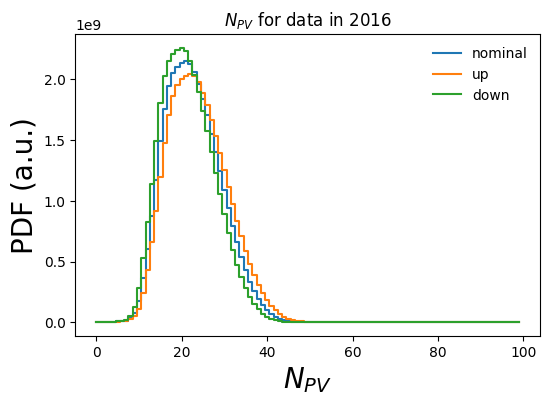

In [232]:
plot_data_hists_raw("/nfshome/jpata/HmmAna/data/pileup/RunII_2016_data.root")
plt.title("$N_{PV}$ for data in 2016")

Text(0.5, 1.0, '$N_{PV}$ for data in 2017')

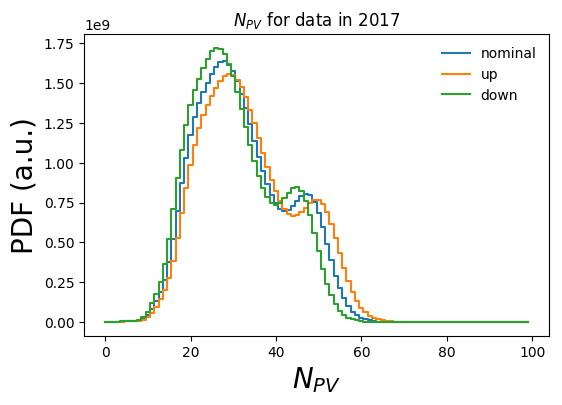

In [233]:
plot_data_hists_raw("/nfshome/jpata/HmmAna/data/pileup/RunII_2017_data.root")
plt.title("$N_{PV}$ for data in 2017")

Text(0.5, 1.0, '$N_{PV}$ for data in 2018ABC')

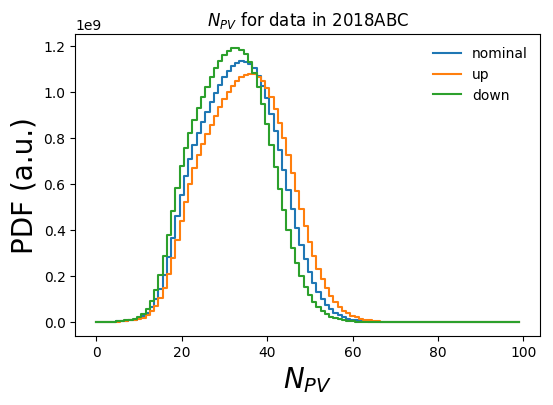

In [234]:
plot_data_hists_raw("/nfshome/jpata/HmmAna/data/pileup/RunII_2018_data.root")
plt.title("2018")
plt.title("$N_{PV}$ for data in 2018ABC")

In [265]:
#https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html
arrays_to_load = [
    "PV_npvsGood",
    "Pileup_nTrueInt"
]

def process_mc(file_nano, file_weight):
    arrs_ggh = load_arrays(file_nano, "Events", arrays_to_load)
    arrs_ggh_weights = load_arrays(file_weight, "Friends", ["puWeight", "puWeightUp", "puWeightDown"])
    
    h1 = Histogram.from_vector(arrs_ggh[b"PV_npvsGood"], bins)
    h2 = Histogram.from_vector(arrs_ggh[b"Pileup_nTrueInt"], bins)
    h3 = Histogram.from_vector(arrs_ggh[b"PV_npvsGood"], bins, weights=arrs_ggh_weights[b"puWeight"])
    h4 = Histogram.from_vector(arrs_ggh[b"PV_npvsGood"], bins, weights=arrs_ggh_weights[b"puWeightUp"])
    h5 = Histogram.from_vector(arrs_ggh[b"PV_npvsGood"], bins, weights=arrs_ggh_weights[b"puWeightDown"])
    
    return Results({"raw": h1, "gen": h2, "weighted": h3, "weighted_up": h4, "weighted_down": h5})

In [266]:
#run for all MC (few seconds for signal)
res = sum([process_mc(files_ggh_nano[i], files_ggh_weights[i]) for i in range(len(files_ggh_nano))], Results({}))

In [269]:
#run for all data (few minutes for SingleMuon)
hists_data = []

f = IntProgress(min=0, max=len(files["data_mu"])) # instantiate the bar
display(f) # display the bar

n_proc = 0
t0 = time.time()
for fi in files["data_mu"]:
    arrs = load_arrays(fi, "Events", ["PV_npvsGood"])
    hh = Histogram.from_vector(arrs[b"PV_npvsGood"], bins)
    f.value += 1
    hists_data += [hh]
    
    n_proc += len(arrs[b"PV_npvsGood"])
    
t1 = time.time()
print("processed {0:.2E} events at {1:.2E} Hz".format(n_proc, n_proc/(t1 - t0)))

hdata = hists_data[0]
for h in hists_data[1:]:
    hdata += h

IntProgress(value=0, max=271)

processed 7.63E+08 events at 4.18E+06 Hz


Text(0.5, 0, 'PV_npvsGood')

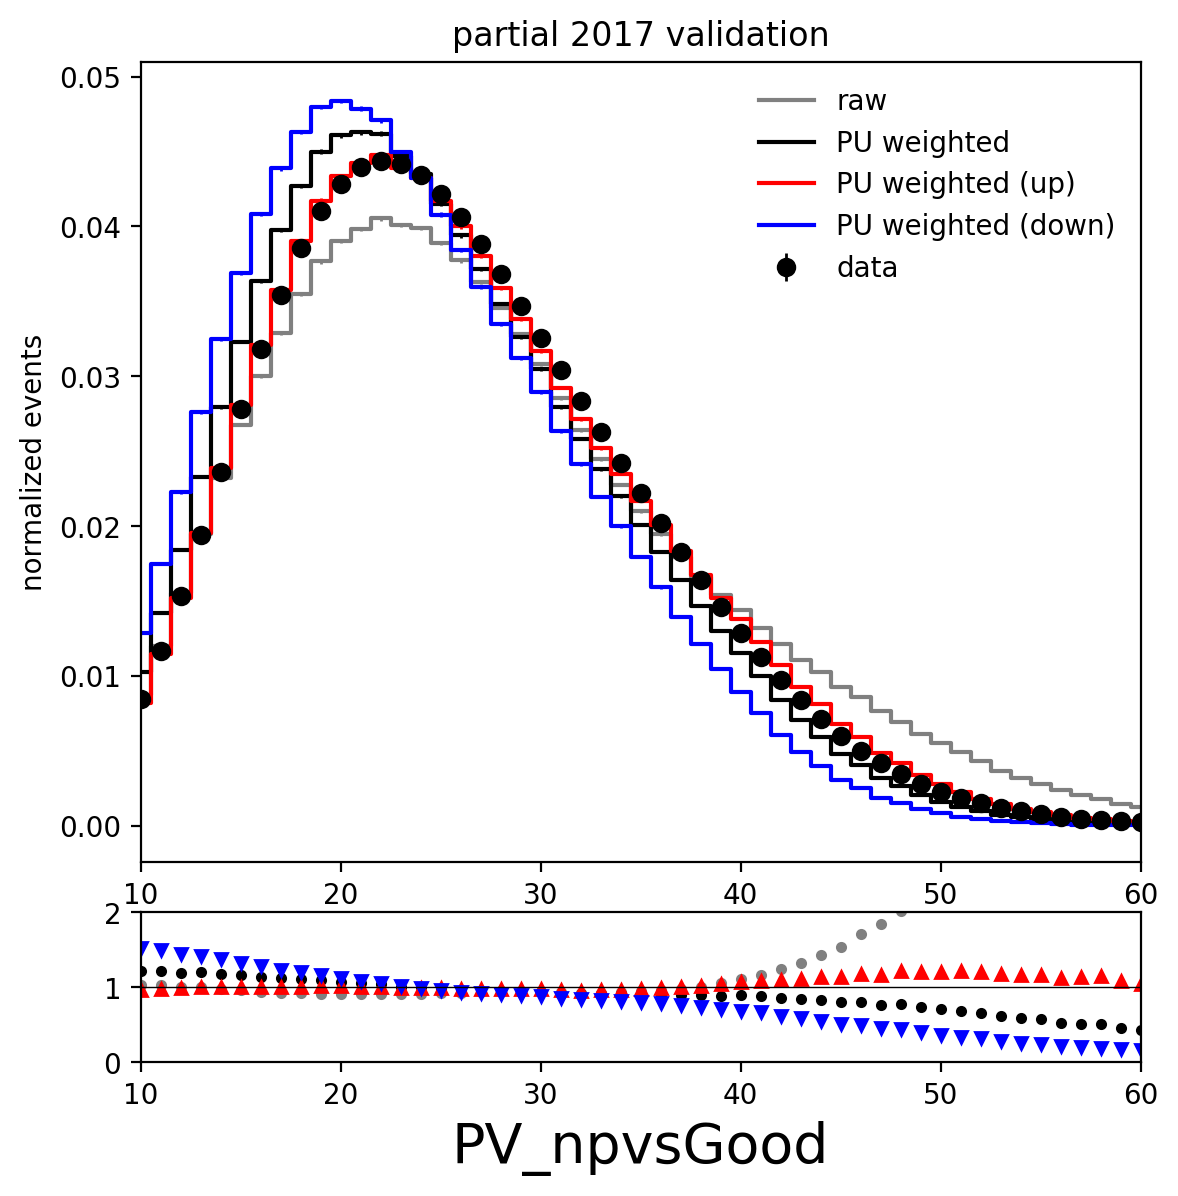

In [280]:
plt.figure(figsize=(5, 5), dpi=200)
a0 = plt.axes((0.0, 0.2, 1.0, 0.8))
plt.title("partial 2017 validation")
plt.ylabel("normalized events")

hdata.normalized().errorbar(label="data", marker="o", color="black")
res["raw"].normalized().step(label="raw", color="gray")

res["weighted"].normalized().step(label="PU weighted", color="black")
res["weighted_up"].normalized().step(label="PU weighted (up)", color="red")
res["weighted_down"].normalized().step(label="PU weighted (down)", color="blue")
plt.legend(frameon=False)

a1 = plt.axes((0.0, 0.0, 1.0, 0.15), sharex=a0)

plt.plot(midpoints(hdata.edges), res["raw"].normalized().contents / hdata.normalized().contents, color="gray", lw=0, marker=".")

plt.plot(midpoints(hdata.edges), res["weighted"].normalized().contents / hdata.normalized().contents, color="black", lw=0, marker=".")
plt.plot(midpoints(hdata.edges), res["weighted_up"].normalized().contents / hdata.normalized().contents, color="red", lw=0, marker="^", ms=4)
plt.plot(midpoints(hdata.edges), res["weighted_down"].normalized().contents / hdata.normalized().contents, color="blue", lw=0, marker="v", ms=4)

plt.ylim(0,2)
plt.xlim(10,60)
plt.axhline(1.0, color="black", lw=0.5)
plt.xlabel("PV_npvsGood", fontsize=20)

In [248]:
s = "1 0.172 9.39 3.48 3.27 1.35 1.41 0.947 1.23 0.602 1.75 1.58 1.51 1.36 1.16 1.07 1.08 1.07 1.14 1.14 1.2 1.2 1.22 1.25 1.27 1.27 1.27 1.27 1.26 1.28 1.25 1.22 1.16 1.12 1.04 0.97 0.926 0.868 0.838 0.789 0.748 0.751 0.803 0.869 0.945 1.1 1.27 1.43 1.49 1.55 1.5 1.31 1.18 0.953 0.735 0.571 0.41 0.285 0.195 0.136 0.0973 0.0691 0.0507 0.0388 0.03 0.0247 0.0173 0.0124 0.0107 0.0101 0.00954 0.00792 0.00796 0.0103 0.00683 0.00741 0.00497 0.00615 0.00544 0.0101 0.00864 0.00501 0.00661 0.00347 0.00376 1 1 0.00299 1 1 1 0.000453 1 1 1 1 1 1 1 1 1 1"

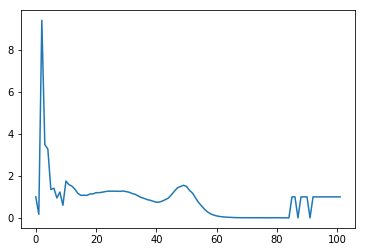

In [250]:
plt.plot(list(map(float, s.split())))
#plt.xlim(10,70)